# tla.py

In [12]:
"""Three-level atom model and integrator.

"""
%load_ext autoreload
import sys
sys.path.append("..") # append the right filepath here
import matplotlib.pyplot as plt


import numpy as np
import darkhistory.physics as phys
import darkhistory.history.reionization as reion
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.misc import derivative

from scipy.interpolate import interp1d
from scipy.integrate import dblquad
from scipy.integrate import quad
from scipy.integrate import trapz
from classy import Class
import math
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Constants
TCMB_0 = 2.3482e-4 # in eV
h = 4.136*1e-15    # in eV s
hbar = h / (2*np.pi) # in eV s
c = 3e8 # in m/s
H0 = 1.43654e-33 # in eV
Omega_r = 8e-5
Omega_m = 0.3165
Omega_Lambda = 1 - Omega_r - Omega_m
ne0 = (1 - 0.25/2)*2.46e-7*(100.)**3 # in m^-3
alpha = 1./137 
lambda_e = 2.426e-10/100. # Compton wavelength of the electron in m
m_e = 0.511e6 # eV
thomson_xsec = 6.6524587158e-25/100.**2 # Thomson scattering in m^2
G = 6.67430e-11*1.6e-19/c**2 # m^3/eV/s^2
e = np.sqrt(4*np.pi*alpha)
# e_coulomb = 1.602176634e-19 # Coulombs
kB = 8.617333262145e-5 # eV/K
mH=1.67e-27*6.24e18*c**2 # eV
mHe=6.6464731e-27*6.24e18*c**2 # eV

# see Domcke and Garcia-Cely
kappa = (16*np.pi*G)**(1/2)/c**2 # s/eV^(1/2)/m^(1/2)
kappa_converted = kappa/np.sqrt(hbar*c)*0.0195592 # s/(m eV) * eV^2/G (= eV s/(m G))
# second factor is to convert G to eV^2; above constructed
# so that kappa^2 B^2 has units of eV^2 s^2/m^2, 
# matching units of omega^2/c^2 in losc, if B
# is supplied in Gauss
        
Omegab0= phys.omega_baryon
YHe = phys.nHe*phys.mHe/(phys.nHe*phys.mHe+phys.nH*mH)

In [3]:
# auxiliary functions; may be better to define locally within get_history() later.

def hubble(z): 
    # in eV. 
    return phys.hubble(1+z)*hbar

def rho_c(z):  
    # returns energy density in eV/m^3
    return 3*hubble(z)**2/(8*np.pi*G)/hbar**2

def nH(z):
    # returns a number per m^3
    return (Omegab0*3*(hubble(0)/hbar)**2/(8*np.pi*G))*(1+z)**3/(mH+(mHe*YHe)/(4*(1-YHe)))

def ne(xe,z):
    # returns a number per m^3
    return xe*nH(z)

def nHe(z):
    # rho_b is given by rho_b0*(1+z)^3 and is equal to mH nH + mHe nHe; solve for nHe:
    # returns a number per m^3
    return (Omegab0*rho_c(0)*(1+z)**3 - mH*nH(z))/mHe

def chi(z):
    # aka nHe/nH
    return nHe(z)/nH(z)
    
def plasma_freq(xe,z):
    # returns a value in eV
    return np.sqrt(e**2*ne(xe,z)*(hbar*c)**(3)/m_e)

def redshifted_B(B0,z):
    return B0*(1+z)**2
    
def mu(x,xe,z):
    # Dimensionless.
    if 1 - np.sqrt(1-plasma_freq(xe,z)**2/(x*TCMB_0*(1+z))**2) >= 1e-13:
        return np.sqrt(1-plasma_freq(xe,z)**2/(x*TCMB_0*(1+z))**2)
    else:
        return 1-plasma_freq(xe,z)**2/(2.*(x*TCMB_0*(1+z))**2) # Taylor expansion (not strictly necessary here)

def losc(x,B0,xe,z): # B0 must be in Gauss
    # returns a length in units m/s/eV; divide by hbar to get a length in m
    # no need to do this conversion now though since K12 is in eV s/m
    if 1 - np.sqrt(1-plasma_freq(xe,z)**2/(x*TCMB_0*(1+z))**2) >= 1e-13:
        return (2./np.sqrt(((x*TCMB_0*(1+z))**2*(1-mu(x,xe,z))**2)/c**2 + kappa_converted**2*redshifted_B(B0,z)**2*(1+z)**2))
    else:
        return (2./np.sqrt(((x*TCMB_0*(1+z))**2*(plasma_freq(xe,z)**2/(2.*(x*TCMB_0*(1+z))**2))**2)/c**2 + kappa_converted**2*redshifted_B(B0,z)**2*(1+z)**2))
        # Taylor expand 1 - mu if mu is too close to 1
        

def delta_l(z,delta_l0=3.0857e22):
    # returns a value in meters (default is delta_l0 = 1 Mpc)
    return delta_l0/(1+z)

def conversion_rate(x,B0,xe,z,delta_l0=3.0857e22): # B must be in Gauss, delta_l in cm
    # returns a value in 1/s.  Multiply by hbar to get a value in eV
    K12 = -1j*np.sqrt(mu(x,xe,z))*kappa_converted*redshifted_B(B0,z)/(1+mu(x,xe,z)) # eV s/m
    return c*np.abs(K12)**2*losc(x,B0,xe,z)**2/(2*delta_l(z,delta_l0))

def particle_density(xe,z):
    # returns a number per m^3
    return nH(z)*(1+xe+chi(z))

In [6]:
def compton_cooling_rate(xHII, xHeII, xHeIII, T_m, rs):
    """Returns the Compton cooling rate.

    Parameters
    ----------
    xHII : float
        n_HII/n_H.
    xHeII : float
        n_HeII/n_H.
    xHeIII : float
        n_HeIII/n_H.
    T_m : float
        The matter temperature.
    rs : float
        The redshift in 1+z.

    Returns
    -------
    float
        The Compton cooling rate in eV/s.

    Notes
    -----
    This is the energy loss rate, *not* the temperature loss rate.

    """
    xe = xHII + xHeII + 2*xHeIII

    return (
        4 * phys.thomson_xsec * 4 * phys.stefboltz / phys.me
        * xe * phys.nH*rs**3 * (phys.TCMB(rs) - T_m)
        * phys.TCMB(rs)**4
    )

In [13]:
def get_history(
    rs_vec, init_cond=None, baseline_f=False,
    inj_particle=None,
    f_H_ion=None, f_H_exc=None, f_heating=None,
    DM_process=None, mDM=None, sigmav=None, lifetime=None,
    struct_boost=None, injection_rate=None, 
    reion_switch=False, reion_rs=None,
    photoion_rate_func=None, photoheat_rate_func=None,
    xe_reion_func=None, helium_TLA=False, f_He_ion=None, 
    GW=None, x0 = None, height = None, width=None,
    mxstep = 1000, rtol=1e-4
):
    """Returns the ionization and thermal history of the IGM.

    Parameters
    ----------
    rs_vec : ndarray
        Abscissa for the solution.
    init_cond : array, optional
        Array containing [initial temperature, initial xHII, initial xHeII, initial xHeIII]. Defaults to standard values if None.
    baseline_f : bool
        If True, uses the baseline f values with no backreaction returned by :func:`.f_std`. Default is False. 
    inj_particle : {'elec', 'phot'}, optional
        Specifies which set of f to use: electron/positron or photon. 
    f_H_ion : function or float, optional
        f(rs, x_HI, x_HeI, x_HeII) for hydrogen ionization. Treated as constant if float.
    f_H_exc : function or float, optional
        f(rs, x_HI, x_HeI, x_HeII) for hydrogen Lyman-alpha excitation. Treated as constant if float.
    f_heating : function or float, optional
        f(rs, x_HI, x_HeI, x_HeII) for heating. Treated as constant if float.
    DM_process : {'swave', 'decay'}, optional
        Dark matter process to use. Default is None.
    sigmav : float, optional
        Thermally averaged cross section for ``DM_process == 'swave'``. Default is None.
    lifetime : float, optional
        Decay lifetime for ``DM_process == 'decay'``. Default is None.
    struct_boost : function, optional
        Energy injection boost factor due to structure formation. Default is None.
    injection_rate : function or float, optional
        Injection rate of DM as a function of redshift. Treated as constant if float. Default is None. 
    reion_switch : bool
        Reionization model included if True.
    reion_rs : float, optional
        Redshift 1+z at which reionization effects turn on.
    photoion_rate_func : tuple of functions, optional
        Functions take redshift 1+z as input, return the photoionization rate in s^-1 of HI, HeI and HeII respectively. If not specified, defaults to `darkhistory.history.reionization.photoion_rate`. 
    photoheat_rate_func : tuple of functions, optional
        Functions take redshift 1+z as input, return the photoheating rate in s^-1 of HI, HeI and HeII respectively. If not specified, defaults to `darkhistory.history.reionization.photoheat_rate`. 
    xe_reion_func : function, optional
        Specifies a fixed ionization history after reion_rs.  
    helium_TLA : bool, optional
        Specifies whether to track helium before reionization. 
    f_He_ion : function or float, optional
        f(rs, x_HI, x_HeI, x_HeII) for helium ionization. Treated as constant if float. If None, treated as zero.
    GW : bool, optional
        Set to "True" to include effects of gravitational waves on dT_m/dz
    x0 : float, optional
        The value at which the GW distribution has its peak
    height: float, optional
        The height of the GW spectrum
    width : float, optional
        The width of the GW spectrum
    mxstep : int, optional
        The maximum number of steps allowed for each integration point. See *scipy.integrate.odeint* for more information.
    rtol : float, optional
        The relative error of the solution. See *scipy.integrate.odeint* for more information.

    Returns
    -------
    list of ndarray
        [temperature solution (in eV), xHII solution, xHeII, xHeIII].

    Notes
    -----
    The actual differential equation that we solve is expressed in terms of y = arctanh(f*(x - f)), where f = 0.5 for x = xHII, and f = nHe/nH * 0.5 for x = xHeII or xHeIII, where nHe/nH is approximately 0.083.

    """

    # Defines the f(z) functions, which return a constant, 
    # if the input fz's are floats. 

    if baseline_f and mDM is None:
        raise ValueError('Specify mDM to use baseline_f.')

    if baseline_f and (
        f_H_ion is not None or f_H_exc is not None
        or f_heating is not None
    ):
        raise ValueError('Use either baseline_f or specify f manually.')

    if baseline_f and (DM_process == 'swave'):
        struct_bool = True
    else:
        struct_bool = False
    
    # set GW parameters based on user input.  x0, height and width are set to
    # some small values if there are no GWs (they will not be used in the calculation)
    if GW is None or GW == False:
        GW = False
        x0 = 1e-12
        height = 0
        width = 1e-12
    elif GW == True:
        GW = True
    else:
        raise TypeError('GW must be True or False (or None).')
        
        
    def _f_H_ion(rs, xHI, xHeI, xHeII):
        if baseline_f: 
            return phys.f_std(
                mDM, rs, inj_particle=inj_particle, inj_type=DM_process, struct=struct_bool,
                channel='H ion'
            )
        if f_H_ion is None:
            return 0.
        elif callable(f_H_ion):
            return f_H_ion(rs, xHI, xHeI, xHeII)
        else:
            return f_H_ion

    def _f_H_exc(rs, xHI, xHeI, xHeII):
        if baseline_f: 
            return phys.f_std(
                mDM, rs, inj_particle=inj_particle, inj_type=DM_process, struct=struct_bool,
                channel='exc'
            )
        if f_H_exc is None:
            return 0.
        elif callable(f_H_exc):
            return f_H_exc(rs, xHI, xHeI, xHeII)
        else:
            return f_H_exc

    def _f_heating(rs, xHI, xHeI, xHeII):
        if baseline_f: 
            return phys.f_std(
                mDM, rs, inj_particle=inj_particle, inj_type=DM_process, struct=struct_bool,
                channel='heat'
            )
        if f_heating is None:
            return 0.
        elif callable(f_heating):
            return f_heating(rs, xHI, xHeI, xHeII)
        else:
            return f_heating
        
    def _f_He_ion(rs, xHI, xHeI, xHeII):
        if f_He_ion is None:
            return 0.
        elif callable(f_He_ion):
            return f_He_ion(rs, xHI, xHeI, xHeII)
        else:
            return f_He_ion

    if DM_process == 'swave' and (sigmav is None or mDM is None):
        raise ValueError('sigmav, mDM must be specified for swave.')
    if DM_process == 'decay' and (lifetime is None or mDM is None):
        raise ValueError('lifetime, mDM must be specified for decay.')
    if DM_process is not None and injection_rate is not None:
        raise ValueError(
            'cannot specify both DM_process and injection_rate.'
        )

    # struct_boost should be defined to just return 1 if undefined.
    if struct_boost is None:
        def struct_boost(rs): 
            return 1.

    def _injection_rate(rs):

        if DM_process == 'swave':
            return (
                phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav) 
                * struct_boost(rs)
            )
        elif DM_process == 'decay':
            return phys.inj_rate('decay', rs, mDM=mDM, lifetime=lifetime)

        else:

            if injection_rate is None:
                return 0.
            elif callable(injection_rate):
                return injection_rate(rs)
            else: 
                return injection_rate
        
    chi = phys.chi

    if reion_switch:

        if photoion_rate_func is None:

            photoion_rate_HI   = reion.photoion_rate('HI')
            photoion_rate_HeI  = reion.photoion_rate('HeI')
            photoion_rate_HeII = reion.photoion_rate('HeII')

        else:

            photoion_rate_HI   = photoion_rate_func[0]
            photoion_rate_HeI  = photoion_rate_func[1]
            photoion_rate_HeII = photoion_rate_func[2]

    if reion_switch:

        if photoheat_rate_func is None:

            photoheat_rate_HI   = reion.photoheat_rate('HI')
            photoheat_rate_HeI  = reion.photoheat_rate('HeI')
            photoheat_rate_HeII = reion.photoheat_rate('HeII')

        else:

            photoheat_rate_HI   = photoheat_rate_func[0]
            photoheat_rate_HeI  = photoheat_rate_func[1]
            photoheat_rate_HeII = photoheat_rate_func[2]

    # Define conversion functions between x and y. 
    def xHII(yHII):
            return 0.5 + 0.5*np.tanh(yHII)
    def xHeII(yHeII):
        return chi/2 + chi/2*np.tanh(yHeII)
    def xHeIII(yHeIII):
        return chi/2 + chi/2*np.tanh(yHeIII)

    def tla_before_reion(rs, var):
        # Returns an array of values for [dT/dz, dyHII/dz,
        # dyHeII/dz, dyHeIII/dz, dtau/dz].
        # var is the [temperature, xHII, xHeII, xHeIII] inputs.

        inj_rate = _injection_rate(rs)
        nH = phys.nH*rs**3
        
        ############## Added code for GWs ##############
        
        # for computing optical depth:
        def g_ff(x, T_e, type=None):
            if type == 'chluba':    
                g_out = 1. + np.log(1. + np.exp(np.sqrt(3.)/np.pi * (np.log(2.25 / x) + 0.5 * np.log(T_e / m_e)) + 1.425))
            else:
                thr = 1e-3
                def approx_high_x_Draine(x, T_e): 
                    theta_e = T_e / m_e
                    return np.log(np.exp(1.) + np.exp(5.960 - np.sqrt(3)/np.pi * np.log(270.783 * x * theta_e**(-0.5))))
                def approx_low_x_Draine(x, T_e):
                    theta_e = T_e / m_e
                    return 4.691 * (
                        1. - 0.118 * np.log(27.0783 * x * theta_e**(-0.5))
                    )
                try:
                    _ = iter(x)
                    g_out = np.zeros_like(x)
                    g_out[x < thr] = approx_high_x_Draine(x[x < thr], T_e[x < thr])
                    g_out[x >= thr] = approx_high_x_Draine(x[x >= thr], T_e[x >= thr])
                except:
                    if x < thr:
                        g_out = approx_high_x_Draine(x, T_e)
                    else:
                        g_out = approx_high_x_Draine(x, T_e)
            return g_out
        
        # for computing optical depth:
        def Lambda_BR(x,z,T_m,x_e): 
            n_p = ne0 * (1.+z)**3 * x_e
            theta_e = T_m / m_e
            x_electron = x * TCMB_0 * (1. + z) / T_m 
            return (
                alpha * lambda_e**3 / (2 * np.pi * np.sqrt(6*np.pi))
                * n_p * theta_e**(-7./2.)
                * g_ff(x_electron, T_m, type='chluba') 
            )
        
        # calculate derivative of log of optical depth wrt redshift
        def dln_tau_ff_dz(tau,z, T_m, xe):
            x = x0
            z_to_int = z 
            x_electron = x * TCMB_0 *(1.+z_to_int) / T_m 
            Lambda = Lambda_BR(x,z_to_int,T_m,xe)
            fac_1 = Lambda * (1 - np.exp(-x_electron)) / x_electron**3
            fac_2 = thomson_xsec * xe * ne0 * (1.+z_to_int)**3 * c / (hubble(z_to_int) / hbar * (1.+z_to_int))
            return 1./tau * fac_1*fac_2
        
        # find dTm/dt due to GWs when the GW spectrum is a delta function
        # this has the optical depth tau as an input to the function; the diff
        # eq solver is also solving for tau at each z, so we can use that as an 
        # input here to find dTm/dt from GWs
        def dTm_dt_GW_deltaFunc(n_func,z,B0,xe,x0,height,z_ini,tau,T_m,delta_l0=3.0857e22):

            z_pts = np.logspace(np.log10(z),np.log10(z_ini-1))
            # omega_GW version
#             y_pts = np.array(list(map(lambda zz: 10**22*(1/hbar)*rho_c(zz)/(1+zz)**3*conversion_rate(x0,B0,zz,delta_l0)*hbar*\
#                             np.exp(-tau)*dln_tau_ff_dz(tau,zz,T_m)*tau, z_pts)))

            # dn_comov/dx version; n_comov is understood to have units m^-3
            y_pts = np.array(list(map(lambda zz: height*conversion_rate(x0,B0,xe,zz,delta_l0)*hbar*\
                            np.exp(-tau)*dln_tau_ff_dz(tau,zz,T_m,xe)*tau*x0*TCMB_0*(1+z), z_pts)))
            
            return 2*(1+z)**3/(3*n_func(xe,z))*trapz(y_pts,x=z_pts) # eV^2

        # tophat spectrum - not used
#         def dTm_dt_GW_tophat(n_func,z,B0,x0,x_width,height,z_ini,tau,T_m,delta_l0=3.0857e22,T0=TCMB_0):
#             # need to convert the conversion rate to eV, hence *hbar
#             # returns a value in eV^2.  Divide by hbar*kB to get a value in K/s.
#             # omega0 in eV
            
# #             def x0(z):
# #                 return omega0/(T0*(1.+z))
        
# #             return 2*(1+z)**3/(3*n_func(z))*\
# #                     dblquad(lambda zz, x: rho_c(zz)/(1+zz)**3*height/x*conversion_rate(x0(zz),B0,zz,delta_l0)*hbar*\
# #                             np.exp(-tau)*dln_tau_ff_dz(tau,zz,T_m)*tau,z,z_ini,lambda zz: (omega0-omega_width/2)/(T0*(1+zz)), lambda zz: (omega0+omega_width/2)/(T0*(1+zz)))[0]
           
#             # dn_comov/dx version
#             return 2*(1+z)**3/(3*n_func(z))*\
#                     dblquad(lambda zz, x: height*conversion_rate(x0,B0,zz,delta_l0)*hbar*\
#                             np.exp(-tau)*dln_tau_ff_dz(tau,zz,T_m)*tau*x*T0*(1+z),z,z_ini,\
#                             lambda zz: (x0-x_width/2), lambda zz: (x0+x_width/2))[0] # should not redshift in x, redshift invt
        
        ############## end added code for GWs ##############
        
        def dlogT_dz(yHII, yHeII, yHeIII, log_T_m, tau, rs):

            T_m = np.exp(log_T_m)
            
            xe = xHII(yHII) + xHeII(yHeII) + 2*xHeIII(yHeIII)
            xHI = 1 - xHII(yHII)
            xHeI = chi - xHeII(yHeII) - xHeIII(yHeIII)        

            # This rate is temperature loss per redshift.
            adiabatic_cooling_rate = 2 * T_m/rs
            
            # if user has specified GWs are present, add to dlogT_dz the term
            # computed above.  Otherwise, add 0.
            if GW:
                grav_factor = 1./T_m * phys.dtdz(rs) * \
                (dTm_dt_GW_deltaFunc(particle_density,rs-1,1e-12,xe,x0,height,3e3,tau,T_m))
                # note I set z_ini = 3000 as opposed to 1000 as we used earlier

            else:
                grav_factor = 0.
            

            return 1 / T_m * adiabatic_cooling_rate + 1 / T_m * (
                phys.dtdz(rs)*(
                    compton_cooling_rate(
                        xHII(yHII), xHeII(yHeII), xHeIII(yHeIII), T_m, rs
                    )
                    + _f_heating(rs, xHI, xHeI, xHeII(yHeII)) * inj_rate
                )
            )/ (3/2 * nH * (1 + chi + xe)) + grav_factor


        def dyHII_dz(yHII, yHeII, yHeIII, log_T_m, rs):

            T_m = np.exp(log_T_m)

            if 1 - xHII(yHII) < 1e-6 and rs < 100:
                # At this point, leave at 1 - 1e-6
                return 0
            # if yHII > 14. or yHII < -14.:
            #     # Stops the solver from wandering too far.
            #     return 0    
            if xHeII(yHeII) > 0.99*chi and rs > 1500:
                # This is prior to helium recombination.
                # Assume H completely ionized.
                return 0

            if helium_TLA and xHII(yHII) > 0.999 and rs > 1500:
                # Use the Saha value. 
                return 2 * np.cosh(yHII)**2 * phys.d_xe_Saha_dz(rs, 'HI')

            if not helium_TLA and xHII(yHII) > 0.99 and rs > 1500:
                # Use the Saha value. 
                return 2 * np.cosh(yHII)**2 * phys.d_xe_Saha_dz(rs, 'HI')


            xe = xHII(yHII) + xHeII(yHeII) + 2*xHeIII(yHeIII)
            ne = xe * nH
            xHI = 1 - xHII(yHII)
            xHeI = chi - xHeII(yHeII) - xHeIII(yHeIII)

            return 2 * np.cosh(yHII)**2 * phys.dtdz(rs) * (
                # Recombination processes. 
                # Boltzmann factor is T_r, agrees with HyREC paper.
                - phys.peebles_C(xHII(yHII), rs) * (
                    phys.alpha_recomb(T_m, 'HI') * xHII(yHII) * xe * nH
                    - 4*phys.beta_ion(phys.TCMB(rs), 'HI') * xHI
                        * np.exp(-phys.lya_eng/phys.TCMB(rs))
                )
                # DM injection. Note that C = 1 at late times.
                + _f_H_ion(rs, xHI, xHeI, xHeII(yHeII)) * inj_rate
                    / (phys.rydberg * nH)
                + (1 - phys.peebles_C(xHII(yHII), rs)) * (
                    _f_H_exc(rs, xHI, xHeI, xHeII(yHeII)) * inj_rate
                    / (phys.lya_eng * nH)
                ) + xHI * ne * reion.coll_ion_rate('HI', T_m)
            ) # added collisional reionization of H

        def dyHeII_dz(yHII, yHeII, yHeIII, log_T_m, rs):

            T_m = np.exp(log_T_m)

            if not helium_TLA: 

                return 0

            if chi - xHeII(yHeII) < 1e-6 and rs < 100:
                # At this point, leave at 1 - 1e-6
                return 0
            
            # Stop the solver from reaching these extremes. 
            if yHeII > 14 or yHeII < -14:
                return 0

            # # Use the Saha values at high ionization. 
            # if xHeII(yHeII) > 0.995*chi: 

            #     # print(phys.d_xe_Saha_dz(rs, 'HeI'))

            #     return (
            #         2/chi * np.cosh(yHeII)**2 * phys.d_xe_Saha_dz(rs, 'HeI')
            #     )

            xe = xHII(yHII) + xHeII(yHeII) + 2*xHeIII(yHeIII)
            ne = xe * nH
            xHI = 1 - xHII(yHII)
            xHeI = chi - xHeII(yHeII) - xHeIII(yHeIII)

            term_recomb_singlet = (
                xHeII(yHeII) * xe * nH * phys.alpha_recomb(T_m, 'HeI_21s')
            )
            term_ion_singlet = (
                phys.beta_ion(phys.TCMB(rs), 'HeI_21s')*(chi - xHeII(yHeII))
                * np.exp(-phys.He_exc_eng['21s']/phys.TCMB(rs))
            )

            term_recomb_triplet = (
                xHeII(yHeII) * xe * nH * phys.alpha_recomb(T_m, 'HeI_23s')
            )
            term_ion_triplet = (
                3*phys.beta_ion(phys.TCMB(rs), 'HeI_23s') 
                * (chi - xHeII(yHeII)) 
                * np.exp(-phys.He_exc_eng['23s']/phys.TCMB(rs))
            )

            return 2/chi * np.cosh(yHeII)**2 * phys.dtdz(rs) * (
                -phys.C_He(xHII(yHII), xHeII(yHeII), rs, 'singlet') * (
                    term_recomb_singlet - term_ion_singlet
                )
                -phys.C_He(xHII(yHII), xHeII(yHeII), rs, 'triplet') * (
                    term_recomb_triplet - term_ion_triplet
                )
                + _f_He_ion(rs, xHI, xHeI, xHeII(yHeII)) * inj_rate
                    / (phys.He_ion_eng * nH)
                # Collisional ionization of HeII to HeIII.
                - xHeII(yHeII) * ne * reion.coll_ion_rate('HeII', T_m)
            )

        def dyHeIII_dz(yHII, yHeII, yHeIII, log_T_m, rs):

            T_m = np.exp(log_T_m)

            if chi - xHeIII(yHeIII) < 1e-6 and rs < 100:
                # At this point, leave at 1 - 1e-6
                return 0

            xe = xHII(yHII) + xHeII(yHeII) + 2*xHeIII(yHeIII)
            ne = xe * nH

            return 2/chi * np.cosh(yHeIII)**2 * phys.dtdz(rs) * (
                # Collisional ionization of HeII into HeIII.
                + xHeII(yHeII) * ne * reion.coll_ion_rate('HeII', T_m)
            )
        
        # added log of optical depth as a quantity the solver should calculate at 
        # each z
        log_T_m, yHII, yHeII, yHeIII, ln_tau = var[0], var[1], var[2], var[3], var[4]

        xe = xHII(yHII) + xHeII(yHeII) + 2*xHeIII(yHeIII)

        return [
            dlogT_dz(yHII, yHeII, yHeIII, log_T_m, np.exp(ln_tau), rs),
            dyHII_dz(yHII, yHeII, yHeIII, log_T_m, rs),
            dyHeII_dz(yHII, yHeII, yHeIII, log_T_m, rs),
            dyHeIII_dz(yHII, yHeII, yHeIII, log_T_m, rs),
            -dln_tau_ff_dz(np.exp(ln_tau),rs-1,np.exp(log_T_m),xe) ,
        ]

    def tla_reion(rs, var):
        # TLA with photoionization/photoheating reionization model.
        # Returns an array of values for [dT/dz, dyHII/dz,
        # dyHeII/dz, dyHeIII/dz].
        # var is the [temperature, xHII, xHeII, xHeIII] inputs.

        inj_rate = _injection_rate(rs)
        nH = phys.nH*rs**3

        def dlogT_dz(yHII, yHeII, yHeIII, log_T_m, rs):

            T_m = np.exp(log_T_m)
            
            xe = xHII(yHII) + xHeII(yHeII) + 2*xHeIII(yHeIII)
            xHI = 1 - xHII(yHII)
            xHeI = chi - xHeII(yHeII) - xHeIII(yHeIII)
            
            # This rate is temperature loss per redshift.
            adiabatic_cooling_rate = 2 * T_m/rs

            # The reionization rates and the Compton rate
            # are expressed in *energy loss* *per second*.

            photoheat_total_rate = nH * (
                xHI * photoheat_rate_HI(rs)
                + xHeI * photoheat_rate_HeI(rs)
                + xHeII(yHeII) * photoheat_rate_HeII(rs)
            )

            compton_rate = phys.dtdz(rs)*(
                compton_cooling_rate(
                    xHII(yHII), xHeII(yHeII), xHeIII(yHeIII), T_m, rs
                )
            ) / (3/2 * nH * (1 + chi + xe))

            dm_heating_rate = phys.dtdz(rs)*(
                _f_heating(rs, xHI, xHeI, xHeII(yHeII)) * inj_rate
            ) / (3/2 * nH * (1 + chi + xe))

            reion_rate = phys.dtdz(rs) * (
                + photoheat_total_rate
                + reion.recomb_cooling_rate(
                    xHII(yHII), xHeII(yHeII), xHeIII(yHeIII), T_m, rs
                )
                + reion.coll_ion_cooling_rate(
                    xHII(yHII), xHeII(yHeII), xHeIII(yHeIII), T_m, rs
                )
                + reion.coll_exc_cooling_rate(
                    xHII(yHII), xHeII(yHeII), xHeIII(yHeIII), T_m, rs
                )
                + reion.brem_cooling_rate(
                    xHII(yHII), xHeII(yHeII), xHeIII(yHeIII), T_m, rs
                )
            ) / (3/2 * nH * (1 + chi + xe))

            return 1 / T_m * (
                adiabatic_cooling_rate + compton_rate 
                + dm_heating_rate + reion_rate
            )

        def dyHII_dz(yHII, yHeII, yHeIII, log_T_m, rs):

            T_m = np.exp(log_T_m)

            if 1 - xHII(yHII) < 1e-6 and rs < 100:
                # At this point, leave at 1 - 1e-6
                return 0


            xe = xHII(yHII) + xHeII(yHeII) + 2*xHeIII(yHeIII)
            ne = xe * nH
            xHI = 1 - xHII(yHII)
            xHeI = chi - xHeII(yHeII) - xHeIII(yHeIII)

            return 2 * np.cosh(yHII)**2 * phys.dtdz(rs) * (
                # DM injection. Note that C = 1 at late times.
                + _f_H_ion(rs, xHI, xHeI, xHeII(yHeII)) * (
                    inj_rate / (phys.rydberg * nH)
                )
                + (1 - phys.peebles_C(xHII(yHII), rs)) * (
                    _f_H_exc(rs, xHI, xHeI, xHeII(yHeII)) 
                    * inj_rate / (phys.lya_eng * nH)
                )
                # Reionization rates.
                + (
                    # Photoionization.
                    xHI * photoion_rate_HI(rs)
                    # Collisional ionization.
                    + xHI * ne * reion.coll_ion_rate('HI', T_m) # add this to before reionization
                    # Recombination.
                    - xHII(yHII) * ne * reion.alphaA_recomb('HII', T_m)
                )
            )

        def dyHeII_dz(yHII, yHeII, yHeIII, log_T_m, rs):

            T_m = np.exp(log_T_m)

            if chi - xHeII(yHeII) < 1e-6 and rs < 100:
                # At this point, leave at 1 - 1e-6
                return 0

            xe = xHII(yHII) + xHeII(yHeII) + 2*xHeIII(yHeIII)
            ne = xe * nH
            xHI = 1 - xHII(yHII)
            xHeI = chi - xHeII(yHeII) - xHeIII(yHeIII)

            return 2/chi * np.cosh(yHeII)**2 * phys.dtdz(rs) * (
                # Photoionization of HeI into HeII.
                xHeI * photoion_rate_HeI(rs)
                # Collisional ionization of HeI to HeII.
                + xHeI * ne * reion.coll_ion_rate('HeI', T_m)
                # Recombination of HeIII to HeII.
                + xHeIII(yHeIII) * ne * reion.alphaA_recomb('HeIII', T_m)
                # Photoionization of HeII to HeIII.
                - xHeII(yHeII) * photoion_rate_HeII(rs)
                # Collisional ionization of HeII to HeIII.
                - xHeII(yHeII) * ne * reion.coll_ion_rate('HeII', T_m)
                # Recombination of HeII into HeI.
                - xHeII(yHeII) * ne * reion.alphaA_recomb('HeII', T_m)
                # DM contribution
                + _f_He_ion(rs, xHI, xHeI, xHeII(yHeII)) * inj_rate
                    / (phys.He_ion_eng * nH)
            )

        def dyHeIII_dz(yHII, yHeII, yHeIII, log_T_m, rs):

            T_m = np.exp(log_T_m)

            if chi - xHeIII(yHeIII) < 1e-6 and rs < 100:
                # At this point, leave at 1 - 1e-6
                return 0

            xe = xHII(yHII) + xHeII(yHeII) + 2*xHeIII(yHeIII)
            ne = xe * nH

            return 2/chi * np.cosh(yHeIII)**2 * phys.dtdz(rs) * (
                # Photoionization of HeII into HeIII.
                xHeII(yHeII) * photoion_rate_HeII(rs)
                # Collisional ionization of HeII into HeIII.
                + xHeII(yHeII) * ne * reion.coll_ion_rate('HeII', T_m)
                # Recombination of HeIII into HeII.
                - xHeIII(yHeIII) * ne * reion.alphaA_recomb('HeIII', T_m)
            )

        log_T_m, yHII, yHeII, yHeIII = var[0], var[1], var[2], var[3]

        # print(rs, T_m, xHII(yHII), xHeII(yHeII), xHeIII(yHeIII))
        
        return [
            dlogT_dz(yHII, yHeII, yHeIII, log_T_m, rs),
            dyHII_dz(yHII, yHeII, yHeIII, log_T_m, rs),
            dyHeII_dz(yHII, yHeII, yHeIII, log_T_m, rs),
            dyHeIII_dz(yHII, yHeII, yHeIII, log_T_m, rs)
        ]

    def tla_reion_fixed_xe(rs, var):
        # TLA with fixed ionization history. 
        # Returns an array of values for [dT/dz, dyHII/dz].]. 
        # var is the [temperature, xHII] input.

        def dxe_dz(rs):

            return derivative(xe_reion_func, rs)

        def dlogT_dz(log_T_m, rs):

            T_m = np.exp(log_T_m)

            xe    = xe_reion_func(rs)
            xHII  = xe * (1. / (1. + chi))
            xHeII = xe * (chi / (1. + chi)) 
            xHI   = 1. - xHII
            xHeI  = chi - xHeII


            # This is the temperature loss per redshift. 
            adiabatic_cooling_rate = 2 * T_m/rs

            return 1 / T_m * (
                adiabatic_cooling_rate
                + (
                    phys.dtdz(rs)*(
                        compton_cooling_rate(xHII, xHeII, 0, T_m, rs)
                        + _f_heating(rs, xHI, xHeI, 0) * _injection_rate(rs)
                    )
                ) / (3/2 * phys.nH*rs**3 * (1 + chi + xe))
            )

        log_T_m = var

        return dlogT_dz(log_T_m, rs)

    if init_cond is None:
        rs_start = rs_vec[0]
        if helium_TLA:
            _init_cond = [
                phys.Tm_std(rs_start), 
                phys.xHII_std(rs_start), 
                phys.xHeII_std(rs_start), 
                1e-12,
                1e-12 # tau
            ]
        else:
            _init_cond = [
                phys.Tm_std(rs_start), 
                phys.xHII_std(rs_start), 
                1e-12, 
                1e-12,
                1e-12 # tau
            ]
    else:
        _init_cond = np.array(init_cond)

        if init_cond[1] == 1:
            _init_cond[1] = 1 - 1e-12
        if init_cond[2] == 0:
            _init_cond[2] = 1e-12
        elif init_cond[2] == chi:
            _init_cond[2] = (1. - 1e-12) * chi
        if init_cond[3] == 0:
            _init_cond[3] = 1e-12
        if init_cond[4] == 0:
            _init_cond[4] = 1e-12 # tau

    _init_cond[0] = np.log(_init_cond[0])
    _init_cond[1] = np.arctanh(2*(_init_cond[1] - 0.5))
    _init_cond[2] = np.arctanh(2/chi * (_init_cond[2] - chi/2))
    _init_cond[3] = np.arctanh(2/chi *(_init_cond[3] - chi/2))
    _init_cond[4] = np.log(_init_cond[4])

    if reion_rs is None: 
        if photoion_rate_func is None and xe_reion_func is None:
            # Default Puchwein model value.
            reion_rs = 16.1
        else:
            raise TypeError('must specify reion_rs if not using default.')


    rs_before_reion_vec = rs_vec[rs_vec > reion_rs]
    rs_reion_vec = rs_vec[rs_vec <= reion_rs]

    if not reion_switch:
        # No reionization model implemented.
        soln = odeint(
                tla_before_reion, _init_cond, rs_vec, 
                mxstep = mxstep, tfirst=True, rtol=rtol
            )
        # print(init_cond)
        # print(rs_vec)
        # soln = solve_ivp(
        #     tla_before_reion, [rs_vec[0], rs_vec[-1]],
        #     init_cond, method='Radau'
        # )
        # print(soln)
    elif xe_reion_func is not None:
        # Fixed xe reionization model implemented. 
        # First, solve without reionization.

        # tfirst=True means that tla_before_reion accepts rs as 
        # first argument.
        soln_no_reion = odeint(
            tla_before_reion, _init_cond, rs_vec, 
            mxstep = mxstep, tfirst=True, rtol=rtol
        )
        # soln_no_reion = solve_ivp(
        #     tla_before_reion, (rs_vec[0], rs_vec[-1]),
        #     init_cond, method='BDF', t_eval=rs_vec
        # )
        # Check if reionization model is required in the first place.
        if rs_reion_vec.size == 0:
            soln = soln_no_reion
            # Convert to xe
            soln[:,1] = 0.5 + 0.5*np.tanh(soln[:,1])
            soln[:,2] = chi/2 + chi/2*np.tanh(soln[:,2])
            soln[:,3] = chi/2 + chi/2*np.tanh(soln[:,2])
        else:
            xHII_no_reion   = 0.5 + 0.5*np.tanh(soln_no_reion[:,1])
            xHeII_no_reion  = chi/2 + chi/2*np.tanh(soln_no_reion[:,2])
            xHeIII_no_reion = chi/2 + chi/2*np.tanh(soln_no_reion[:,3])
            
            xe_no_reion = xHII_no_reion + xHeII_no_reion + xHeIII_no_reion

            xe_reion    = xe_reion_func(rs_vec)
            # Find where to solve the TLA. Must lie below reion_rs and 
            # have xe_reion > xe_no_reion.

            # Earliest redshift index where xe_reion > xe_no_reion. 
            # min because redshift is in decreasing order.
            where_xe = np.min(np.argwhere(xe_reion > xe_no_reion))
            # Redshift index where rs_vec < reion_rs. 
            where_rs = np.min(np.argwhere(rs_vec < reion_rs))
            # Start at the later redshift, i.e. the larger index. 
            where_start = np.max([where_xe, where_rs])
            # Define the boolean mask.
            where_new_soln = (np.arange(rs_vec.size) >= where_start)


            # Find the respective redshift arrays. 
            rs_above_std_xe_vec = rs_vec[where_new_soln]
            rs_below_std_xe_vec = rs_vec[~where_new_soln]
            # Append the last redshift before reionization model. 
            rs_above_std_xe_vec = np.insert(
                rs_above_std_xe_vec, 0, rs_below_std_xe_vec[-1]
            )

            # Define the solution array. Get the entries from soln_no_reion.
            soln = np.zeros_like(soln_no_reion)
            # Copy Tm, xHII, xHeII only before reionization.
            soln[~where_new_soln, :3] = soln_no_reion[~where_new_soln, :3]
            # Copy xHeIII entirely with no reionization for now.
            soln[:, 3] = soln_no_reion[:, 3]
            # Convert to xe.
            soln[~where_new_soln, 1] = 0.5 + 0.5*np.tanh(
                soln[~where_new_soln, 1]
            )
            soln[~where_new_soln, 2] = chi/2 + chi/2*np.tanh(
                soln[~where_new_soln, 2]
            )
            soln[:, 3] = chi/2 + chi/2*np.tanh(soln[:, 3])


            # Solve for all subsequent redshifts. 
            if rs_above_std_xe_vec.size > 0:
                init_cond_fixed_xe = soln[~where_new_soln, 0][-1]
                soln_with_reion = odeint(
                    tla_reion_fixed_xe, init_cond_fixed_xe, 
                    rs_above_std_xe_vec, mxstep=mxstep, rtol=rtol, 
                    tfirst=True
                )
                # Remove the initial step, save to soln.
                soln[where_new_soln, 0] = np.squeeze(soln_with_reion[1:])
                # Put in the solutions for xHII and xHeII. 
                soln[where_new_soln, 1] = xe_reion_func(
                    rs_vec[where_new_soln]
                ) * (1. / (1. + phys.chi))
                soln[where_new_soln, 2] = xe_reion_func(
                    rs_vec[where_new_soln]
                ) * (phys.chi / (1. + phys.chi))

        # Convert from log_T_m to T_m
        soln[:,0] = np.exp(soln[:,0])

        return soln

    else:
        # Reionization model implemented. 
        # First, check if required in the first place. 
        if rs_reion_vec.size == 0:
            soln = odeint(
                tla_before_reion, _init_cond, 
                rs_before_reion_vec, mxstep = mxstep, rtol=rtol, tfirst=True
            )
            # soln = solve_ivp(
            #     tla_before_reion, 
            #     (rs_before_reion_vec[0], rs_before_reion_vec[-1]),
            #     init_cond, method='BDF', t_eval=rs_before_reion_vec
            # )
        # Conversely, solving before reionization may be unnecessary.
        elif rs_before_reion_vec.size == 0:
            soln = odeint(
                tla_reion, _init_cond, rs_reion_vec, 
                mxstep = mxstep, rtol=rtol, tfirst=True
            )
            # soln = solve_ivp(
            #     tla_reion, (rs_reion_vec[0], rs_reion_vec[-1]),
            #     init_cond, method='BDF', t_eval=rs_reion_vec
            # )
        # Remaining case straddles both before and after reionization.
        else:
            # First, solve without reionization up to rs = reion_rs.
            rs_before_reion_vec = np.append(rs_before_reion_vec, reion_rs)
            soln_before_reion = odeint(
                tla_before_reion, _init_cond, 
                rs_before_reion_vec, mxstep = mxstep, tfirst=True, rtol=rtol
            )
            # soln_before_reion = solve_ivp(
            #     tla_before_reion, 
            #     (rs_before_reion_vec[0], rs_before_reion_vec[-1]),
            #     init_cond, method='BDF', t_eval=rs_before_reion_vec
            # )
            # Next, solve with reionization starting from reion_rs.
            rs_reion_vec = np.insert(rs_reion_vec, 0, reion_rs)
            # Initial conditions taken from last step before reionization.
            init_cond_reion = [
                soln_before_reion[-1,0],
                soln_before_reion[-1,1],
                soln_before_reion[-1,2],
                soln_before_reion[-1,3]
            ]
            soln_reion = odeint(
                tla_reion, init_cond_reion, 
                rs_reion_vec, mxstep = mxstep, tfirst=True, rtol=rtol
            )
            # soln_reion = solve_ivp(
            #     tla_reion, (rs_reion_vec[0], rs_reion_vec[-1]),
            #     init_cond, method='BDF', t_eval=rs_reion_vec
            # )
            # Stack the solutions. Remove the solution at 16.1.
            soln = np.vstack((soln_before_reion[:-1,:], soln_reion[1:,:]))

    soln[:,0] = np.exp(soln[:,0])
    soln[:,1] = 0.5 + 0.5*np.tanh(soln[:,1])
    soln[:,2] = (
        chi/2 + chi/2*np.tanh(soln[:,2])
    )
    soln[:,3] = (
        chi/2 + chi/2*np.tanh(soln[:,3])
    )

    return soln

# Get History

In [14]:
rs_vec = np.flipud(np.arange(1., 3000., 1))

In [15]:
soln_no_GW = get_history(rs_vec, helium_TLA=True,reion_switch=False)

In [16]:
# last two arguments are GW spectrum parameters
soln_with_GW = get_history(rs_vec, helium_TLA=True,GW=True,reion_switch=False,x0=1e-2,height=1e52)

<ipython-input-13-b2de7e89be41>:290: RuntimeWarning: invalid value encountered in log10
  z_pts = np.logspace(np.log10(z),np.log10(z_ini-1))


(1400.0, 3000.0, 0.95, 1.13)

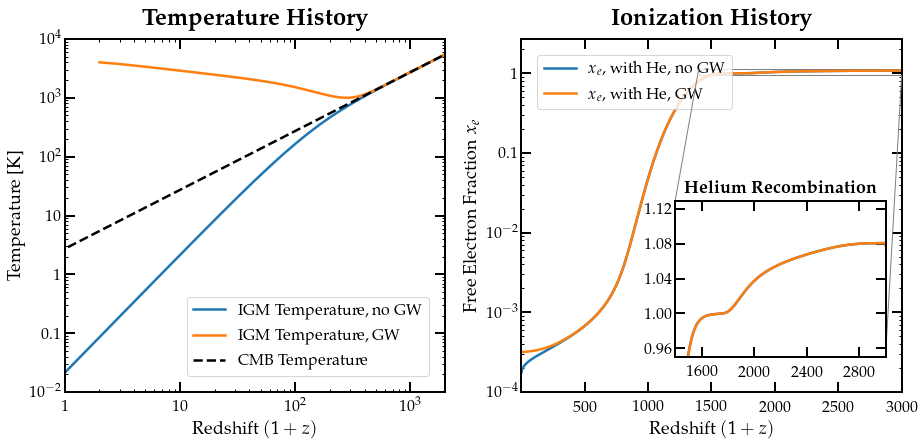

In [17]:
Tm_no_GW = soln_no_GW[:,0]/phys.kB
Tm_GW = soln_with_GW[:,0]/phys.kB

xe_no_GW   = soln_no_GW[:,1] +  soln_no_GW[:,2]
# The other columns with xHeII and xHeIII are negligible.
xe_with_GW = soln_with_GW[:,1] + soln_with_GW[:,2]
#The last column with xHeIII is negligible


fig_He = plt.figure(figsize=(15,6.5))

ax = plt.subplot(1,2,1)

plt_T_IGM_no_GW, = plt.plot(rs_vec, Tm_no_GW, label='IGM Temperature, no GW')
plt_T_IGM_GW, = plt.plot(rs_vec, Tm_GW, label='IGM Temperature, GW')
# Plot the CMB temperature for comparison, using the function phys.TCMB
plt_T_CMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB Temperature')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[plt_T_IGM_no_GW,plt_T_IGM_GW, plt_T_CMB], loc=4)


plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel('Temperature [K]')
plt.axis([1, 2e3, 1e-2, 1e4])

ax = plt.subplot(1,2,2)

plt_GW,    = plt.plot(rs_vec, xe_no_GW, label=r'$x_e$, with He, no GW')
plt_no_GW, = plt.plot(rs_vec, xe_with_GW,   label=r'$x_e$, with He, GW')

plt.legend(handles=[plt_GW, plt_no_GW], loc=2)

# ax.set_xscale('log')
ax.set_yscale('log')

plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Free Electron Fraction $x_e$')
plt.axis([1, 3e3, 1e-4, 2.7])

from matplotlib.transforms import blended_transform_factory
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

transform = blended_transform_factory(fig_He.transFigure, ax.transAxes)
axins = inset_axes(ax,  width="22%", height="50%",
                    bbox_to_anchor=(0, 0.1, 0.885, 0.885),
                    bbox_transform=transform, loc=4, borderpad=0)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.plot(rs_vec, xe_no_GW)
plt.plot(rs_vec, xe_with_GW)
plt.title(r'\bf{Helium Recombination}', fontsize=18, y = 0.95)
plt.yticks([0.96, 1., 1.04, 1.08, 1.12])
plt.xticks([1600, 2000, 2400, 2800])
plt.axis([1.4e3, 3e3, 0.95, 1.13])

# Scratch

In [12]:
x0=1e-1

def g_ff(x, T_e, type=None):
            if type == 'chluba':    
                g_out = 1. + np.log(1. + np.exp(np.sqrt(3.)/np.pi * (np.log(2.25 / x) + 0.5 * np.log(T_e / m_e)) + 1.425))
            else:
                thr = 1e-3
                def approx_high_x_Draine(x, T_e): 
                    theta_e = T_e / m_e
                    return np.log(np.exp(1.) + np.exp(5.960 - np.sqrt(3)/np.pi * np.log(270.783 * x * theta_e**(-0.5))))
                def approx_low_x_Draine(x, T_e):
                    theta_e = T_e / m_e
                    return 4.691 * (
                        1. - 0.118 * np.log(27.0783 * x * theta_e**(-0.5))
                    )
                try:
                    _ = iter(x)
                    g_out = np.zeros_like(x)
                    g_out[x < thr] = approx_high_x_Draine(x[x < thr], T_e[x < thr])
                    g_out[x >= thr] = approx_high_x_Draine(x[x >= thr], T_e[x >= thr])
                except:
                    if x < thr:
                        g_out = approx_high_x_Draine(x, T_e)
                    else:
                        g_out = approx_high_x_Draine(x, T_e)
            return g_out

def Lambda_BR(x, x_e, z,T_m): # here
            n_p = ne0 * (1.+z)**3 * x_e
            theta_e = T_m / m_e # here
            x_electron = x * TCMB_0 * (1. + z) / T_m # here
            return (
                alpha * lambda_e**3 / (2 * np.pi * np.sqrt(6*np.pi))
                * n_p * theta_e**(-7./2.)
        #         * g_ff(x_electron, T_e(z), type='chluba')
                * g_ff(x_electron, T_m, type='chluba') # here
            )
        
def dln_tau_ff_dz(tau,z, T_m):
            x = x0
            z_to_int = z 
#             x_electron = x * TCMB_0 *(1.+z_to_int) / T_e(z) 
            x_electron = x * TCMB_0 *(1.+z_to_int) / T_m # here
#             Lambda = Lambda_BR(x, x_e(z_to_int), z_to_int)
            Lambda = Lambda_BR(x, x_e(z_to_int), z_to_int,T_m) # here
            fac_1 = Lambda * (1 - np.exp(-x_electron)) / x_electron**3
            fac_2 = thomson_xsec * x_e(z_to_int) * ne0 * (1.+z_to_int)**3 * c / (hubble(z_to_int) / hbar * (1.+z_to_int))
#             print("z:",z,"T_m",T_m)
#             print("Lambda:",Lambda,"x_electron:",x_electron)
#             print("fac1:",fac_1)
#             print("fac2:",fac_2)
#             print("dtau:",fac_1*fac_2)
            return 1./tau * fac_1*fac_2


def dTm_dt_GW_tophat(n_func,z,B0,x0,x_width,height,z_ini,tau,T_m,delta_l0=3.0857e22,T0=TCMB_0):
            # need to convert the conversion rate to eV, hence *hbar
            # returns a value in eV^2.  Divide by hbar*kB to get a value in K/s.
            # omega0 in eV
            
            print(np.sqrt(e**2*ne(z)*(hbar*c)**(3)/m_e))
            
#             def x0(z):
#                 return omega0/(T0*(1.+z))
        
#             return 2*(1+z)**3/(3*n_func(z))*\
#                     dblquad(lambda zz, x: rho_c(zz)/(1+zz)**3*height/x*conversion_rate(x0(zz),B0,zz,delta_l0)*hbar*\
#                             np.exp(-tau)*dln_tau_ff_dz(tau,zz,T_m)*tau,z,z_ini,lambda zz: (omega0-omega_width/2)/(T0*(1+zz)), lambda zz: (omega0+omega_width/2)/(T0*(1+zz)))[0]
            
            # dn_comov/dx version
            return 2*(1+z)**3/(3*n_func(z))*\
                    dblquad(lambda zz, x: height*conversion_rate(x0,B0,zz,delta_l0)*hbar*\
                            np.exp(-tau)*dln_tau_ff_dz(tau,zz,T_m)*tau*x*T0*(1+z),z,z_ini,lambda zz: (x0-x_width/2), lambda zz: (x0+x_width/2))[0]



In [13]:
dTm_dt_GW_tophat(particle_density,100,1e1-2,x0,1e0,1e10,3000,1e-14,.234,delta_l0=3.0857e22,T0=TCMB_0)
# there doesn't seem to be a problem here...
# I'm unclear about why the width might affect this anyway

TypeError: ne() missing 1 required positional argument: 'z'

In [ ]:
plt.plot(plasma_freq(np.logspace(0,3)))
# this never goes negative...